In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression


In [12]:
start = dt.datetime.now()

In [13]:
!ls ../input/keras-pretrained-models/

Kuszma.JPG
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [14]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [15]:
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

In [16]:
!ls ~/.keras/models

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [17]:
!ls ../input/dog-breed-identification

labels.csv  sample_submission.csv  test  train


In [18]:
INPUT_SIZE = 224
NUM_CLASSES = 16
SEED = 1987
data_dir = '../input/dog-breed-identification'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10223 10222
10358 10357


In [19]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed')['target'].rank(method='first')
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [20]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

Instructions for updating:
Colocations handled automatically by placer.


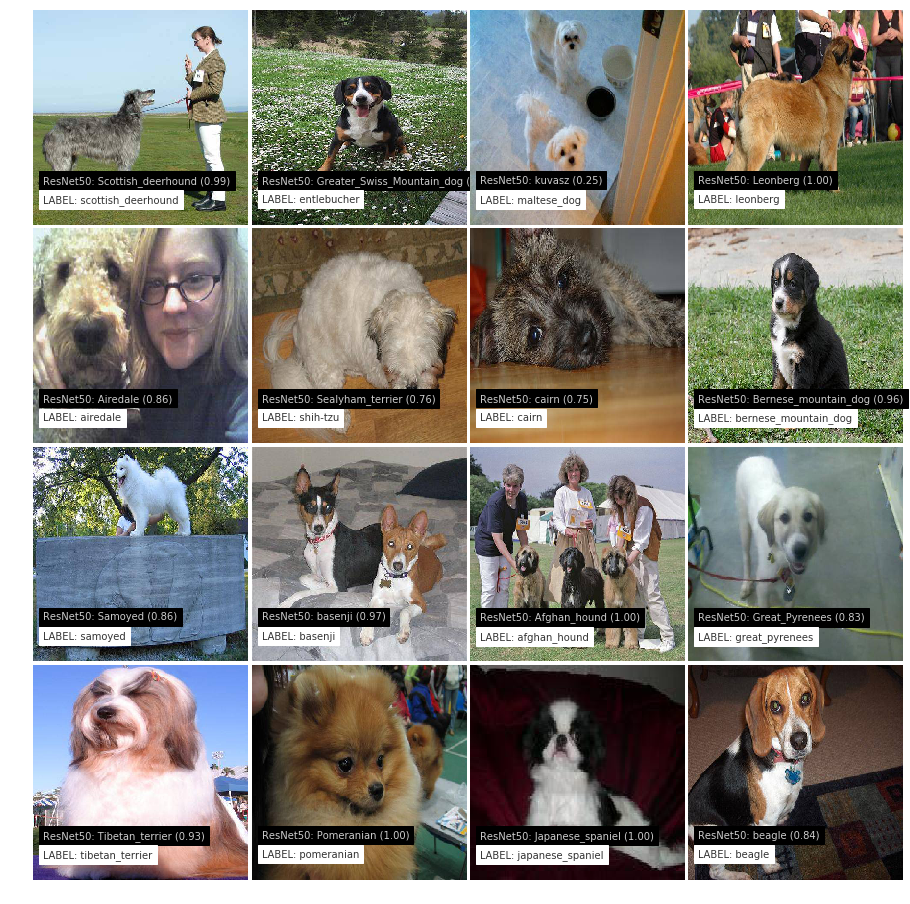

In [21]:
model = ResNet50(weights='imagenet')
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 2, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

In [22]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:10, 168.19it/s]

Train Images shape: (1777, 224, 224, 3) size: 267,488,256


In [23]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

((1409, 224, 224, 3), (368, 224, 224, 3), (1409, 16), (368, 16))
368/368 [==============================] - 1s 4ms/step
VGG train bottleneck features shape: (1409, 512) size: 721,408
VGG valid bottleneck features shape: (368, 512) size: 188,416


In [24]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [25]:
print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation VGG LogLoss 0.3521862347494172
Validation VGG Accuracy 0.9184782608695652


In [26]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:10, 173.40it/s]

Train Images shape: (1777, 299, 299, 3) size: 476,596,731


In [27]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
368/368 [==============================] - 2s 6ms/step
Xception train bottleneck features shape: (1409, 2048) size: 2,885,632
Xception valid bottleneck features shape: (368, 2048) size: 753,664


In [28]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.06823407711372875
Validation Xception Accuracy 0.9809782608695652


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [29]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
368/368 [==============================] - 2s 4ms/step
InceptionV3 train bottleneck features shape: (1409, 2048) size: 2,885,632
InceptionV3 valid bottleneck features shape: (368, 2048) size: 753,664


In [30]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_i_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [31]:
print('Validation Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Inception LogLoss 0.08059209808531405
Validation Inception Accuracy 0.967391304347826


In [32]:
X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])
print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
print('Validation Xception + Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception + Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Full train bottleneck features shape: (1409, 4096) size: 5,771,264
Full valid bottleneck features shape: (368, 4096) size: 1,507,328
Validation Xception + Inception LogLoss 0.07086021803597498
Validation Xception + Inception Accuracy 0.9755434782608695


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


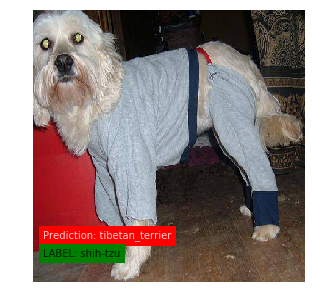

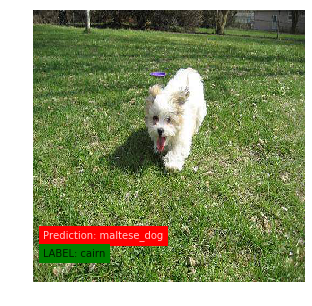

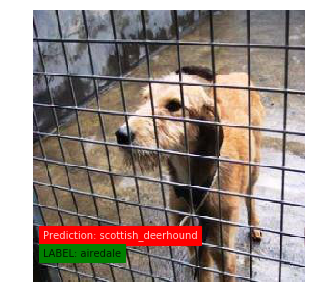

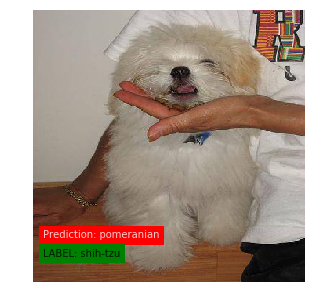

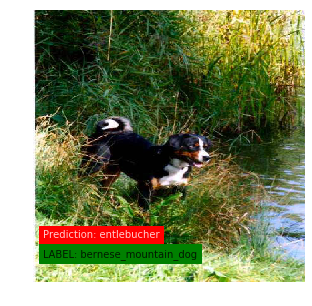

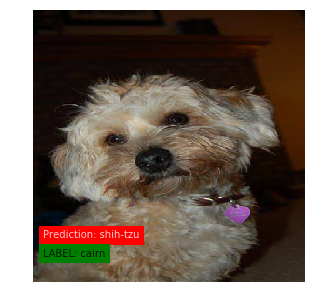

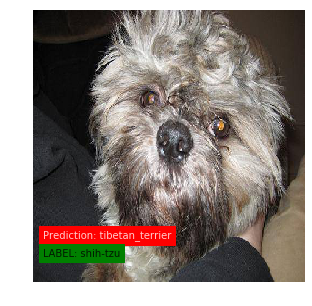

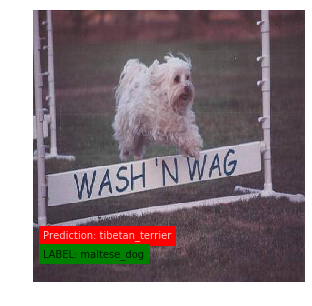

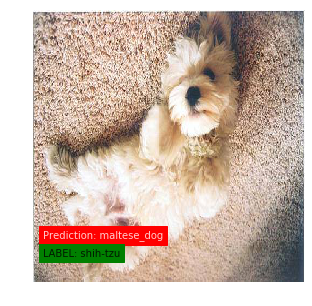

In [35]:
valid_breeds = (yv * range(NUM_CLASSES)).sum(axis=1)
error_idx = (valid_breeds != valid_preds)
for img_id, breed, pred in zip(labels.loc[valid_idx, 'id'].values[error_idx],
                                [selected_breed_list[int(b)] for b in valid_preds[error_idx]],
                                [selected_breed_list[int(b)] for b in valid_breeds[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = read_img(img_id, 'train', (299, 299))
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: %s' % pred, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'LABEL: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()           

In [34]:
end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))
print('We almost used the one hour time limit.')

Total time 538 s.
We almost used the one hour time limit.
